In [1]:
import numpy as np
import pandas as pd
import glob
import json
import os
import sys
import urllib.request
import requests
from bs4 import BeautifulSoup
import time
from selenium import webdriver
import datetime as dt
import pymysql

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
# arima 모델 import

In [3]:
# dowjones's db to DataFrame

def selectDJ() : 
    tmp_df = pd.DataFrame([])
    
    tmp_date = np.array([])
    tmp_close = np.array([])
    tmp_open = np.array([])
    tmp_high = np.array([])
    tmp_low = np.array([])
    tmp_volume = np.array([])
    
    conn = pymysql.connect(host='localhost', port=3306,
                           user='acorn12', passwd='acorn12', db='acorn', charset='utf8')
    try:
        with conn.cursor() as cursor:
            sql = 'SELECT dj_date, dj_close, dj_open, dj_high, dj_low, dj_volume FROM dowjones '

            cursor.execute(sql)
            conn.commit()

            rows = cursor.fetchall()
            
            for i in range(len(rows)) :
                tmp_date = np.append(tmp_date, rows[i][0])
                tmp_close = np.append(tmp_close, rows[i][1])
                tmp_open = np.append(tmp_open, rows[i][2])
                tmp_high = np.append(tmp_high, rows[i][3])
                tmp_low = np.append(tmp_low, rows[i][4])
                tmp_volume = np.append(tmp_volume, rows[i][5])
                
    finally:
        conn.close()
    
    tmp_df['date'] = tmp_date.astype('datetime64[ns]')
    tmp_df['close'] = tmp_close
    tmp_df['open'] = tmp_open
    tmp_df['high'] = tmp_high
    tmp_df['low'] = tmp_low
    tmp_df['volume'] = tmp_volume
    
    tmp_df = tmp_df.set_index('date')
    
    return(tmp_df)

In [4]:
# gold's db to DataFrame

def selectGold() : 
    tmp_df = pd.DataFrame([])
    
    tmp_date = np.array([])
    tmp_close = np.array([])
    tmp_open = np.array([])
    tmp_high = np.array([])
    tmp_low = np.array([])
    tmp_volume = np.array([])
    
    conn = pymysql.connect(host='localhost', port=3306,
                           user='acorn12', passwd='acorn12', db='acorn', charset='utf8')
    try:
        with conn.cursor() as cursor:
            sql = 'SELECT gold_date, gold_close, gold_open, gold_high, gold_low, gold_volume '
            sql += 'FROM gold '

            cursor.execute(sql)
            conn.commit()

            rows = cursor.fetchall()
            
            for i in range(len(rows)) :
                tmp_date = np.append(tmp_date, rows[i][0])
                tmp_close = np.append(tmp_close, rows[i][1])
                tmp_open = np.append(tmp_open, rows[i][2])
                tmp_high = np.append(tmp_high, rows[i][3])
                tmp_low = np.append(tmp_low, rows[i][4])
                tmp_volume = np.append(tmp_volume, rows[i][5])
                
    finally:
        conn.close()
    
    tmp_df['date'] = tmp_date.astype('datetime64[ns]')
    tmp_df['close'] = tmp_close
    tmp_df['open'] = tmp_open
    tmp_df['high'] = tmp_high
    tmp_df['low'] = tmp_low
    tmp_df['volume'] = tmp_volume
    
    tmp_df = tmp_df.set_index('date')
    
    return(tmp_df)

In [5]:
# bitcoin's db to DataFrame

def selectBitcoin() : 
    tmp_df = pd.DataFrame([])
    
    tmp_date = np.array([])
    tmp_close = np.array([])
    tmp_open = np.array([])
    tmp_high = np.array([])
    tmp_low = np.array([])
    tmp_volume = np.array([])
    
    conn = pymysql.connect(host='localhost', port=3306,
                           user='acorn12', passwd='acorn12', db='acorn', charset='utf8')
    try:
        with conn.cursor() as cursor:
            sql = 'SELECT bit_date, bit_close, bit_open, bit_high, bit_low, bit_volume '
            sql += 'FROM bitcoin '

            cursor.execute(sql)
            conn.commit()

            rows = cursor.fetchall()
            
            for i in range(len(rows)) :
                tmp_date = np.append(tmp_date, rows[i][0])
                tmp_close = np.append(tmp_close, rows[i][1])
                tmp_open = np.append(tmp_open, rows[i][2])
                tmp_high = np.append(tmp_high, rows[i][3])
                tmp_low = np.append(tmp_low, rows[i][4])
                tmp_volume = np.append(tmp_volume, rows[i][5])
                
    finally:
        conn.close()
    
    tmp_df['date'] = tmp_date.astype('datetime64[ns]')
    tmp_df['close'] = tmp_close
    tmp_df['open'] = tmp_open
    tmp_df['high'] = tmp_high
    tmp_df['low'] = tmp_low
    tmp_df['volume'] = tmp_volume
    
    tmp_df = tmp_df.set_index('date')
    
    return(tmp_df)

In [6]:
# get all Data in db

dowjones_DF = selectDJ()
gold_DF = selectGold()
bitcoin_DF = selectBitcoin()

In [ ]:
# Close DB 제작 


In [19]:
# Close DB 채워넣기

dowjones_DF = selectDJ()
gold_DF = selectGold()
bitcoin_DF = selectBitcoin()

dowjones_subDF = dowjones_DF.loc[:,['close','open']]
gold_subDF = gold_DF.loc[:,['close','open']]
bitcoin_subDF = bitcoin_DF.loc[:,['close','open']]

dowjones_subDF = dowjones_subDF.add_prefix('dj_')
gold_subDF = gold_subDF.add_prefix('gol_')
bitcoin_subDF = bitcoin_subDF.add_prefix('bit_')

result_sub = pd.concat([bitcoin_subDF, gold_subDF, dowjones_subDF], axis = 1, sort=False)

# na 값에 대해서 padding 처리한 과정 : 값이 없으면 전날 데이터 기준으로 들어간다

beforeDate = result_sub.index[0]

for date in result_sub.index :
    for cols in result_sub.columns :
        if pd.isnull(result_sub.at[date,cols]) == True :
            result_sub.at[date,cols] = result_sub.at[beforeDate,cols]
    beforeDate = date


# db연결해서 중복된 값 안받아오게끔 하기
conn = pymysql.connect(host='localhost', port=3306,user='acorn12', passwd='acorn12', db='acorn', charset='utf8')

try:
    with conn.cursor() as cursor:
        sql = 'SELECT IFNULL(MAX(cl_date),"2013-01-01") FROM al_close '
        
        cursor.execute(sql)
        
        rows = cursor.fetchone()
        lastDate = rows[0]
        
        # db에 기록된 가장 최근값과 오늘의 날짜 반납( 이 기준으로 db에서 가져옴)
        
        recentlyDate = pd.to_datetime(lastDate).date()
        recentlyDate += dt.timedelta(days=1) # 하루 추가하기(다음날로 확인하는 거)
        today = dt.datetime.now().date()
        
        result_sub_update = result_sub.loc[recentlyDate:,:]
        
        if recentlyDate < today :
            for date in result_sub_update.index :

                sql = 'INSERT INTO al_close(cl_date, cl_bitcoin, cl_gold, cl_dowjones) '
                sql += 'VALUES(%s,%s,%s,%s) '

                cursor.execute(sql,(date.date(),float(result_sub_update.at[date,'bit_close']),float(result_sub_update.at[date,'gol_close']),float(result_sub_update.at[date,'dj_close'])) )


        conn.commit()

finally:
    conn.close()

In [30]:
result_sub

,bit_close,bit_open,gol_close,gol_open,dj_close,dj_open
date,,,,,,
2013-01-02,13.28,13.28,1687.90,1672.80,13412.55,13104.30
2013-01-03,13.40,13.40,1673.70,1686.10,13391.36,13413.01
2013-01-04,13.50,13.50,1648.10,1647.00,13435.21,13391.05
2013-01-05,13.44,13.44,1648.10,1647.00,13435.21,13391.05
2013-01-06,13.45,13.45,1648.10,1647.00,13435.21,13391.05
...,...,...,...,...,...,...
2020-01-26,8621.60,8351.10,1581.95,1571.65,28989.73,29230.39
2020-01-27,8912.00,8622.00,1580.25,1582.40,28533.15,28542.49
2020-01-28,9393.70,8912.10,1580.15,1580.30,28722.03,28594.28


In [71]:
featureTrain = result_sub.loc['2017-01-01':'2020-01-20','bit_close']
featureTest = result_sub.loc['2020-01-21':,'bit_close']

In [31]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# p-value 보는거
from statsmodels.tsa.stattools import adfuller

In [140]:
# arima 예측하는거 5일치 함수

def arima_predict(df, typeData) :
    
    if typeData == 'gol' :
        orders =(0,2,1)
    else :
        orders = (1,2,2)
    
    beforeYear= dt.datetime.now().date().replace(year=dt.datetime.now().year-3)
    testDate = dt.datetime.now().date().replace(day=dt.datetime.now().day-5)
    
    featureTrain = result_sub.loc[beforeYear:testDate,typeData+'_close']
    featureTest = result_sub.loc[testDate:,typeData+'_close']
    
    arima_model = ARIMA(featureTrain, order=orders)
    arima_fit = arima_model.fit(trend='nc', full_output=True, disp=1)
    
    arima_predict = arima_fit.forecast(steps=5)
    featureTest
    
    return (arima_predict[0],featureTest)
    
    
    

In [115]:
bit_pred, bit_test = arima_predict(result_sub,'bit')

C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [119]:
dj_pred, dj_test = arima_predict(result_sub,'dj')

C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
예측결과가 똥임

In [141]:
gol_pred, gol_test = arima_predict(result_sub, 'gol')

C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [142]:
gol_pred, gol_test

(array([1572.1918754 , 1572.48375081, 1572.77562621, 1573.06750162,
        1573.35937702]), date
 2020-01-25    1571.90
 2020-01-26    1581.95
 2020-01-27    1580.25
 2020-01-28    1580.15
 2020-01-29    1576.70
 2020-01-30    1575.95
 Name: gol_close, dtype: float64)

In [122]:
dj_pred, dj_test

(array([28992.46637686, 29005.87588157, 29009.66099916, 29022.12481233,
        29026.76269788]), date
 2020-01-25    28989.73
 2020-01-26    28989.73
 2020-01-27    28533.15
 2020-01-28    28722.03
 2020-01-29    28735.70
 2020-01-30    28735.70
 Name: dj_close, dtype: float64)

In [123]:
bit_pred, bit_test

(array([8341.00969243, 8363.1896987 , 8358.16373933, 8374.36398887,
        8374.00346087]), date
 2020-01-25    8353.7
 2020-01-26    8621.6
 2020-01-27    8912.0
 2020-01-28    9393.7
 2020-01-29    9304.2
 2020-01-30    9322.5
 Name: bit_close, dtype: float64)

In [75]:
beforeYear= dt.datetime.now().date().replace(year=dt.datetime.now().year-3)
print(beforeYear)

testDate = dt.datetime.now().date().replace(day=dt.datetime.now().day-5)
print(testDate)

2017-01-30
2020-01-25


In [76]:
featureTrain = result_sub.loc[beforeYear:testDate,'bit_close']
featureTest = result_sub.loc[testDate:,'bit_close']

In [84]:
from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(featureTrain.dropna())[1])

p-value: 0.13793836326069048


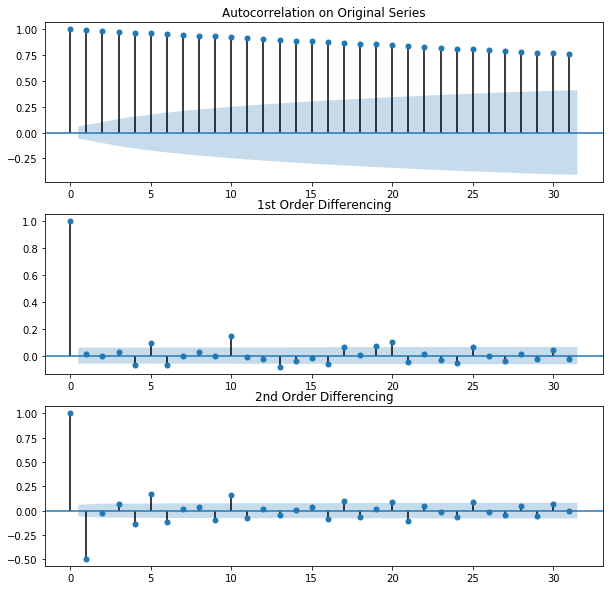

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(featureTrain, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(featureTrain.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(featureTrain.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

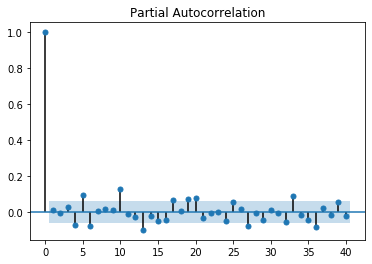

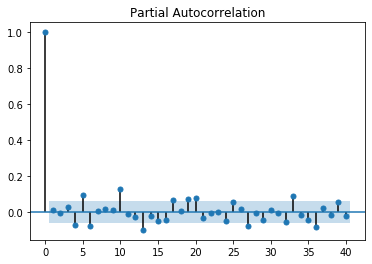

In [86]:
plot_pacf(featureTrain.diff().dropna(), lags=40)

In [88]:
import pmdarima as pm

In [125]:
beforeYear= dt.datetime.now().date().replace(year=dt.datetime.now().year-3)
print(beforeYear)

testDate = dt.datetime.now().date().replace(day=dt.datetime.now().day-5)
print(testDate)

featureTrain = result_sub.loc[beforeYear:testDate,'gol_close']
featureTest = result_sub.loc[testDate:,'gol_close']

2017-01-30
2020-01-25


In [126]:
arima_model = ARIMA(featureTrain, order=(1,2,2))

C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [128]:
arima_model = ARIMA(featureTrain, order=(1,1,1))
arima_fit = arima_model.fit(trend='nc', full_output=True, disp=1)
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.gol_close   No. Observations:                 1090
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4175.142
Method:                       css-mle   S.D. of innovations             11.150
Date:                Thu, 30 Jan 2020   AIC                           8356.284
Time:                        18:21:00   BIC                           8371.266
Sample:                    01-31-2017   HQIC                          8361.955
                         - 01-25-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.gol_close     0.4712      0.077      6.123      0.000       0.320       0.622
ma.L1.D.gol_close    -0.6783      0.063    -10.736      0.000      -0.802      -0.554
                        

C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


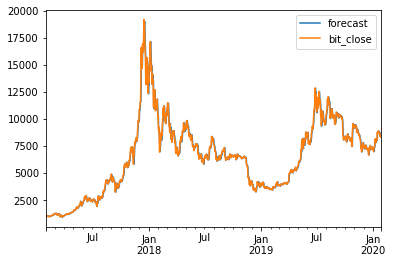

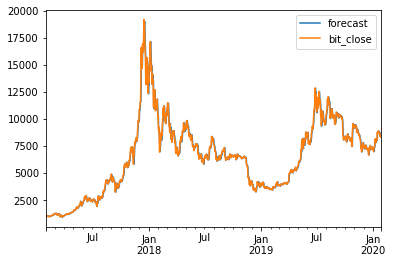

In [80]:
arima_fit.plot_predict()

In [105]:
arima_predict = arima_fit.forecast(steps=5)
print(arima_predict[0])

[8341.00969243 8363.1896987  8358.16373933 8374.36398887 8374.00346087]


In [109]:
featureTest

pandas.core.series.Series

In [89]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.bit_close   No. Observations:                 1090
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -7990.523
Method:                       css-mle   S.D. of innovations            369.373
Date:                Thu, 30 Jan 2020   AIC                          15989.046
Time:                        15:58:55   BIC                          16009.021
Sample:                    01-31-2017   HQIC                         15996.606
                         - 01-25-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.bit_close    -0.7655      0.091     -8.374      0.000      -0.945      -0.586
ar.L2.D.bit_close    -0.0394      0.032     -1.243      0.214      -0.101       0.023
ma.L1.D.bit_close     0.7829      0.087      9.030      0.000       0.613       0.953
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4084           +0.0000j            1.4084            0.5000
AR.2          -18.0244           +0.0000j           18.0244            0.5000
MA.1           -1.2774           +0.0000j            1.2774            0.5000
-----------------------------------------------------------------------------
"""

In [96]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1,
                              max_p=5,
                              start_q=1,
                              max_q=5,
                              test="kpss",
                              seasonal=True,
                              trace=True)
    return automodel

In [91]:
def plotarima(n_periods, timeseries, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="W")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    plt.show()

C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\dev\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=15990.262, BIC=16010.238, Fit time=0.270 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=15991.483, BIC=16001.471, Fit time=0.020 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=15993.335, BIC=16008.317, Fit time=0.043 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=15993.340, BIC=16008.322, Fit time=0.043 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=15989.853, BIC=15994.847, Fit time=0.009 seconds
Total fit time: 0.386 seconds


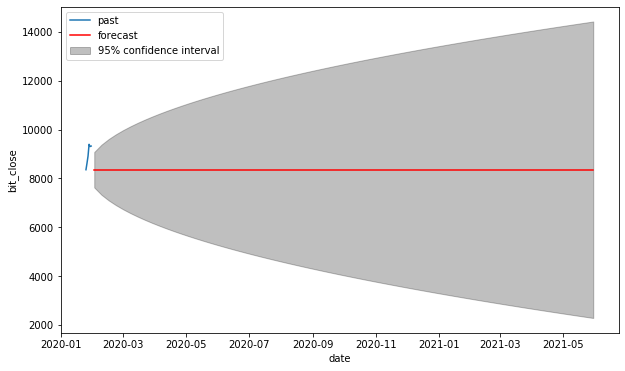

In [100]:
automodel = arimamodel(featureTrain)
plotarima(70, featureTest, automodel)

In [17]:
# padding 안된값있는지 확인
for cols in result_sub.columns :
    print(result_sub.loc[:,cols].isnull().value_counts())

False    2578
Name: bit_close, dtype: int64
False    2578
Name: bit_open, dtype: int64
False    2578
Name: gol_close, dtype: int64
False    2578
Name: gol_open, dtype: int64
False    2578
Name: dj_close, dtype: int64
False    2578
Name: dj_open, dtype: int64


In [13]:
result_sub.loc[recentlyDate:,:]

,bit_close,bit_open,gol_close,gol_open,dj_close,dj_open
date,,,,,,
2020-01-29,9304.2,9390.9,1576.70,1567.65,28735.7,28820.53
2020-01-30,9322.5,9305.1,1575.95,1576.65,28735.7,28820.53


In [7]:
dowjones_subDF = dowjones_DF.loc[:,['close','open']]
gold_subDF = gold_DF.loc[:,['close','open']]
bitcoin_subDF = bitcoin_DF.loc[:,['close','open']]

In [8]:
dowjones_subDF = dowjones_subDF.add_prefix('dj_')
gold_subDF = gold_subDF.add_prefix('gol_')
bitcoin_subDF = bitcoin_subDF.add_prefix('bit_')

In [8]:
bitcoin_DF

,close,open,high,low,volume
date,,,,,
2013-01-02,13.28,13.28,13.28,13.28,0.0
2013-01-03,13.40,13.40,13.40,13.40,0.0
2013-01-04,13.50,13.50,13.50,13.50,0.0
2013-01-05,13.44,13.44,13.44,13.44,0.0
2013-01-06,13.45,13.45,13.45,13.45,0.0
...,...,...,...,...,...
2020-01-18,8891.50,8873.10,8965.00,8794.23,3460.0
2020-01-19,8694.00,8891.60,9169.50,8455.70,12410.0
2020-01-20,8667.44,8698.60,8720.00,8630.00,9260.0


In [14]:
result = pd.concat([dowjones_DF,gold_DF,bitcoin_DF], axis=1, sort=False)

In [9]:
result_sub = pd.concat([bitcoin_subDF, gold_subDF, dowjones_subDF], axis = 1, sort=False)

In [9]:
result_sub

,bit_close,bit_open,gol_close,gol_open,dj_close,dj_open
date,,,,,,
2013-01-02,13.28,13.28,1687.90,1672.80,13412.55,13104.30
2013-01-03,13.40,13.40,1673.70,1686.10,13391.36,13413.01
2013-01-04,13.50,13.50,1648.10,1647.00,13435.21,13391.05
2013-01-05,13.44,13.44,NaN,NaN,NaN,NaN
2013-01-06,13.45,13.45,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-01-18,8891.50,8873.10,NaN,NaN,NaN,NaN
2020-01-19,8694.00,8891.60,1557.05,1557.40,NaN,NaN
2020-01-20,8667.44,8698.60,1562.05,1557.20,NaN,NaN


In [10]:
result

,close,open,high,low,volume,close,open,high,low,volume,close,open,high,low,volume
2013-01-02,13412.55,13104.30,13412.71,13104.30,161430000.0,1687.9,1672.8,1693.8,1670.0,40.0,13.28,13.28,13.28,13.28,0.0
2013-01-03,13391.36,13413.01,13430.60,13358.30,129630000.0,1673.7,1686.1,1686.8,1662.0,140.0,13.40,13.40,13.40,13.40,0.0
2013-01-04,13435.21,13391.05,13447.11,13376.23,107590000.0,1648.1,1647.0,1658.3,1625.7,200.0,13.50,13.50,13.50,13.50,0.0
2013-01-07,13384.29,13436.13,13436.13,13343.32,113120000.0,1645.5,1656.5,1659.9,1643.8,50.0,13.59,13.59,13.59,13.59,0.0
2013-01-08,13328.85,13377.42,13377.42,13293.13,129570000.0,1661.5,1647.7,1659.5,1647.7,20.0,13.74,13.74,13.74,13.74,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7369.83,7371.80,7422.00,7297.70,4270.0
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7364.60,7370.30,7509.90,7315.80,4450.0
2020-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8013.80,8184.30,8271.90,7994.60,4250.0
2020-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8174.70,8013.63,8174.70,7951.70,3210.0


In [15]:
result.dropna()

,close,open,high,low,volume,close,open,high,low,volume,close,open,high,low,volume
2013-01-02,13412.55,13104.30,13412.71,13104.30,161430000.0,1687.9,1672.8,1693.8,1670.0,40.0,13.28,13.28,13.28,13.28,0.0
2013-01-03,13391.36,13413.01,13430.60,13358.30,129630000.0,1673.7,1686.1,1686.8,1662.0,140.0,13.40,13.40,13.40,13.40,0.0
2013-01-04,13435.21,13391.05,13447.11,13376.23,107590000.0,1648.1,1647.0,1658.3,1625.7,200.0,13.50,13.50,13.50,13.50,0.0
2013-01-07,13384.29,13436.13,13436.13,13343.32,113120000.0,1645.5,1656.5,1659.9,1643.8,50.0,13.59,13.59,13.59,13.59,0.0
2013-01-08,13328.85,13377.42,13377.42,13293.13,129570000.0,1661.5,1647.7,1659.5,1647.7,20.0,13.74,13.74,13.74,13.74,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-14,28939.67,28895.50,29054.16,28872.27,296040000.0,1544.6,1548.6,1549.5,1536.4,340910.0,8775.60,8104.10,8829.00,8099.30,16570.0
2020-01-15,29030.22,28901.80,29127.59,28897.35,263430000.0,1554.0,1546.8,1558.8,1546.5,310070.0,8807.70,8760.84,8873.00,8560.20,8780.0
2020-01-16,29297.64,29131.95,29300.32,29131.95,252110000.0,1550.5,1556.6,1558.2,1548.0,260050.0,8720.60,8810.90,8839.90,8579.80,5310.0
2020-01-17,29348.10,29313.31,29373.62,29289.91,336870000.0,1560.3,1553.0,1561.4,1549.3,264930.0,8875.40,8719.55,8994.90,8674.20,9690.0


In [21]:
result_sub_drop = result_sub.dropna()

In [15]:
result_sub.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22'],
              dtype='datetime64[ns]', name='date', length=2570, freq=None)

In [ ]:
result_sub.at['2013-01-05','bit_close']

In [22]:
# 데이터를 한데모으고 이에 대해 빈값은 지워버렸음 0은 살리고, NaN 값만 지움

# 그리고 suffix,prefix 로 값을 넣어주는 형태로 해결해야함 : 완료
# 이와같이하면 안되고 peding 처리를 해야함 NaN 값에 대해서 전 값을 똑같이 집어넣어준다

result_sub_drop

,close,open,close,open,close,open
2013-01-02,13.28,13.28,1687.9,1672.8,13412.55,13104.30
2013-01-03,13.40,13.40,1673.7,1686.1,13391.36,13413.01
2013-01-04,13.50,13.50,1648.1,1647.0,13435.21,13391.05
2013-01-07,13.59,13.59,1645.5,1656.5,13384.29,13436.13
2013-01-08,13.74,13.74,1661.5,1647.7,13328.85,13377.42
...,...,...,...,...,...,...
2020-01-14,8775.60,8104.10,1544.6,1548.6,28939.67,28895.50
2020-01-15,8807.70,8760.84,1554.0,1546.8,29030.22,28901.80
2020-01-16,8720.60,8810.90,1550.5,1556.6,29297.64,29131.95
2020-01-17,8875.40,8719.55,1560.3,1553.0,29348.10,29313.31


In [40]:
result_sub = result_sub.sort_index(axis=0)

In [100]:
np.isnan(result_sub.loc[result_sub.index[4],'gol_close'])

True

In [124]:
result_sub.loc[:,'gol_close'].isnull()

2013-01-02    False
2013-01-03    False
2013-01-04    False
2013-01-05     True
2013-01-06     True
              ...  
2020-01-18     True
2020-01-19    False
2020-01-20    False
2020-01-21    False
2020-01-22    False
Name: gol_close, Length: 2570, dtype: bool

In [10]:
# na 값에 대해서 padding 처리한 과정 : 값이 없으면 전날 데이터 기준으로 들어간다

beforeDate = result_sub.index[0]

for date in result_sub.index :
    for cols in result_sub.columns :
        if pd.isnull(result_sub.at[date,cols]) == True :
            result_sub.at[date,cols] = result_sub.at[beforeDate,cols]
    beforeDate = date
    

In [10]:
# padding 안된값있는지 확인
for cols in result_sub.columns :
    print(result_sub.loc[:,cols].isnull().value_counts())

False    2575
Name: bit_close, dtype: int64
False    2575
Name: bit_open, dtype: int64
False    2575
Name: gol_close, dtype: int64
False    2575
Name: gol_open, dtype: int64
False    2575
Name: dj_close, dtype: int64
False    2575
Name: dj_open, dtype: int64


In [11]:
result_sub

,bit_close,bit_open,gol_close,gol_open,dj_close,dj_open
date,,,,,,
2013-01-02,13.28,13.28,1687.90,1672.80,13412.55,13104.30
2013-01-03,13.40,13.40,1673.70,1686.10,13391.36,13413.01
2013-01-04,13.50,13.50,1648.10,1647.00,13435.21,13391.05
2013-01-05,13.44,13.44,1648.10,1647.00,13435.21,13391.05
2013-01-06,13.45,13.45,1648.10,1647.00,13435.21,13391.05
...,...,...,...,...,...,...
2020-01-23,8724.80,8734.20,1565.40,1558.90,29160.09,29111.02
2020-01-24,8724.80,8734.20,1571.90,1562.90,28989.73,29230.39
2020-01-26,8724.80,8734.20,1581.95,1571.65,28989.73,29230.39


In [ ]:
result_sub.loc[:,['bit_close','bit_open']]

In [52]:
type(float(result_sub.at[result_sub.index[1],'bit_close']))

float

In [12]:
result_sub.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2020-01-18', '2020-01-19', '2020-01-20', '2020-01-21',
               '2020-01-22', '2020-01-23', '2020-01-24', '2020-01-26',
               '2020-01-27', '2020-01-28'],
              dtype='datetime64[ns]', name='date', length=2575, freq=None)

In [53]:
def insertClose(df) : 
    
    conn = pymysql.connect(host='localhost', port=3306,
                           user='acorn12', passwd='acorn12', db='acorn', charset='utf8')
    try:
        with conn.cursor() as cursor:
            
            for date in result_sub.index :
                
                sql = 'INSERT INTO al_close(cl_date, cl_bitcoin, cl_gold, cl_dowjones) '
                sql += 'VALUES(%s,%s,%s,%s) '

                cursor.execute(sql,(date.date(),float(result_sub.at[date,'bit_close']),float(result_sub.at[date,'gol_close']),float(result_sub.at[date,'dj_close'])) )

            conn.commit()
                
    finally:
        conn.close()
    

In [11]:
conn = pymysql.connect(host='localhost', port=3306,
                           user='acorn12', passwd='acorn12', db='acorn', charset='utf8')
try:
    with conn.cursor() as cursor:

        for date in result_sub.index :

            sql = 'INSERT INTO al_close(cl_date, cl_bitcoin, cl_gold, cl_dowjones) '
            sql += 'VALUES(%s,%s,%s,%s) '

            cursor.execute(sql,(date.date(),float(result_sub.at[date,'bit_close']),float(result_sub.at[date,'gol_close']),float(result_sub.at[date,'dj_close'])) )

        conn.commit()

finally:
    conn.close()

IntegrityError: (1062, "Duplicate entry '2013-01-02' for key 'PRIMARY'")

In [28]:
result_sub.at[date,'gol_close']

1580.15

In [44]:
result_new = result_sub.iloc[1500:,:]

In [84]:
beforeYear= dt.datetime.now().date().replace(year=dt.datetime.now().year-2)
beforeYear

datetime.date(2018, 1, 23)

In [85]:
result_new = result_sub.loc[beforeYear:,:]

In [13]:
result_new = result_sub.loc[dt.datetime(2017,1,1).date():,:]

In [ ]:
result_new = result_sub.loc[:,:]

In [68]:
result_new

,bit_close,bit_open,gol_close,gol_open,dj_close,dj_open
2017-01-23,910.03,923.72,1276.60,1276.60,19799.85,19794.79
2017-01-24,886.10,908.41,1271.80,1271.80,19912.71,19794.68
2017-01-25,893.35,886.10,1258.80,1258.80,20068.51,19994.48
2017-01-26,915.12,893.35,1250.60,1250.60,20100.91,20076.25
2017-01-27,916.70,915.12,1249.40,1246.00,20093.78,20103.36
...,...,...,...,...,...,...
2020-01-18,8891.50,8873.10,1560.30,1553.00,29348.10,29313.31
2020-01-19,8694.00,8891.60,1557.05,1557.40,29348.10,29313.31
2020-01-20,8667.44,8698.60,1562.05,1557.20,29348.10,29313.31
2020-01-21,8734.10,8638.20,1557.90,1557.30,29196.04,29269.05


In [12]:
corr = result_sub.corr(method='pearson')

In [13]:
print(corr)

           bit_close  bit_open  gol_close  gol_open  dj_close   dj_open
bit_close   1.000000  0.997905   0.156959  0.152992  0.865958  0.865712
bit_open    0.997905  1.000000   0.157612  0.153590  0.866022  0.865840
gol_close   0.156959  0.157612   1.000000  0.998173 -0.022841 -0.024420
gol_open    0.152992  0.153590   0.998173  1.000000 -0.027844 -0.029507
dj_close    0.865958  0.866022  -0.022841 -0.027844  1.000000  0.999381
dj_open     0.865712  0.865840  -0.024420 -0.029507  0.999381  1.000000


In [57]:
corr.iat[0,0]

1.0

In [ ]:
# bit_close와 dj_close는 의외로 노은 상관관계를 가지고 있음을 알수 있다.

In [69]:
print(result_new.corr(method='pearson'))

           bit_close  bit_open  gol_close  gol_open  dj_close   dj_open
bit_close   1.000000  0.994118   0.473515  0.472763  0.646654  0.646566
bit_open    0.994118  1.000000   0.474936  0.473990  0.648785  0.649023
gol_close   0.473515  0.474936   1.000000  0.996531  0.521949  0.521530
gol_open    0.472763  0.473990   0.996531  1.000000  0.520399  0.519283
dj_close    0.646654  0.648785   0.521949  0.520399  1.000000  0.997060
dj_open     0.646566  0.649023   0.521530  0.519283  0.997060  1.000000


In [86]:
method = ['pearson', 'kendall', 'spearman']

for m in method :
    print('\n' + m + '\n')
    print(result_new.corr(method=m))


pearson

           bit_close  bit_open  gol_close  gol_open  dj_close   dj_open
bit_close   1.000000  0.990211   0.585097  0.585971  0.339856  0.343023
bit_open    0.990211  1.000000   0.584458  0.585529  0.337016  0.340895
gol_close   0.585097  0.584458   1.000000  0.996283  0.557282  0.559288
gol_open    0.585971  0.585529   0.996283  1.000000  0.558231  0.558759
dj_close    0.339856  0.337016   0.557282  0.558231  1.000000  0.987855
dj_open     0.343023  0.340895   0.559288  0.558759  0.987855  1.000000

kendall

           bit_close  bit_open  gol_close  gol_open  dj_close   dj_open
bit_close   1.000000  0.914665   0.399998  0.399366  0.218073  0.219941
bit_open    0.914665  1.000000   0.398881  0.397895  0.215474  0.217734
gol_close   0.399998  0.398881   1.000000  0.946064  0.276582  0.276789
gol_open    0.399366  0.397895   0.946064  1.000000  0.277955  0.278350
dj_close    0.218073  0.215474   0.276582  0.277955  1.000000  0.908463
dj_open     0.219941  0.217734   0.276789  0

(6.0, 0.0)

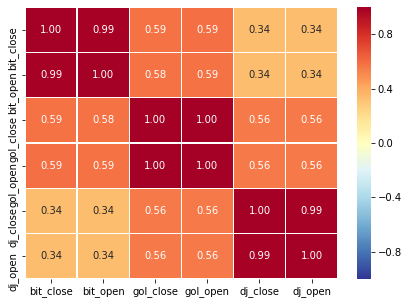

In [100]:
plt.figure(figsize = (7,5))
hm = sns.heatmap(data=result_new.corr(method='pearson'), annot=True, fmt = '.2f', linewidths = .5,
            cmap='RdYlBu_r', vmin = -1, vmax = 1)
# 위 아래 0.5씩 더 줘서 꼬이는게 없어지게 하는 경우
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)

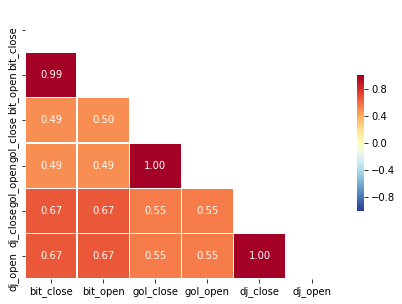

In [15]:
# 그림 사이즈 지정
fig, ax = plt.subplots(figsize=(7,5))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래삼각형에 False)

mask = np.zeros_like(result_new.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

hm = sns.heatmap(data=result_new.corr(), annot=True, fmt = '.2f', linewidths = .5,
            mask=mask, cbar_kws={'shrink':.5},
            cmap='RdYlBu_r', vmin = -1, vmax = 1)

bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)

# 경로에는 절대적인 경로 및 상대적인 경로가 모두 가능하다
outImgPath = 'C:/dev/info file/output.jpg'
fig.savefig(outImgPath)

In [97]:
hm.get_ylim()

(5.5, 0.5)

In [65]:
result_sub.index[0]

datetime.date(2013, 1, 2)

In [ ]:
beforeYear= dt.datetime.now().date().replace(year=dt.datetime.now().year-2)
beforeYear